In [1]:
!python -m pip install --upgrade pip
!python -m pip install --upgrade pymupdf

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 8.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [1]:
import os
import warnings

import pandas as pd
import seaborn as sns

from utils.datasets import PDFDataset
from utils.parsers import Parser

warnings.filterwarnings('ignore')

In [3]:
dataset = PDFDataset("data")
parser = Parser()

AssertionError: 

In [7]:
sents = []
for pdf in tqdm(dataset):
    sents += parser.get_sentences(pdf['path'])

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [00:33<00:00,  8.26it/s]


In [69]:
df = pd.DataFrame({"text": sents})
df.to_csv("data/sents/spbu_sents_temp_2.csv", encoding='utf-8')

# find anomalies

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv("data/sents/spbu_sents_temp_2.csv")

In [4]:
df['sent_len'] = df.text.apply(len)

In [5]:
df['text_lower'] = df.text.apply(lambda x: x.lower())

In [6]:
df.describe()

,Unnamed: 0,sent_len
count,84960.000000,84960.000000
mean,42479.500000,137.709193
std,24525.983772,70.690341
min,0.000000,11.000000
25%,21239.750000,87.000000
50%,42479.500000,124.000000
75%,63719.250000,173.000000
max,84959.000000,511.000000


<AxesSubplot:xlabel='sent_len', ylabel='Count'>

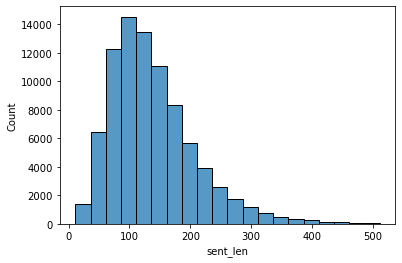

In [7]:
sns.histplot(data=df, x='sent_len', bins=20)